# Task Demo Analysis

In [5]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt

DATA_DIR = '../_data'
def load_data(filename):
    path = os.path.join(DATA_DIR, filename)
    df = pd.read_csv(path)
    for col in ['correct', 'rt', 'response_time']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def add_jitter(x, width=0.1):
    return x + np.random.uniform(-width, width, size=len(x))

## Flanker task

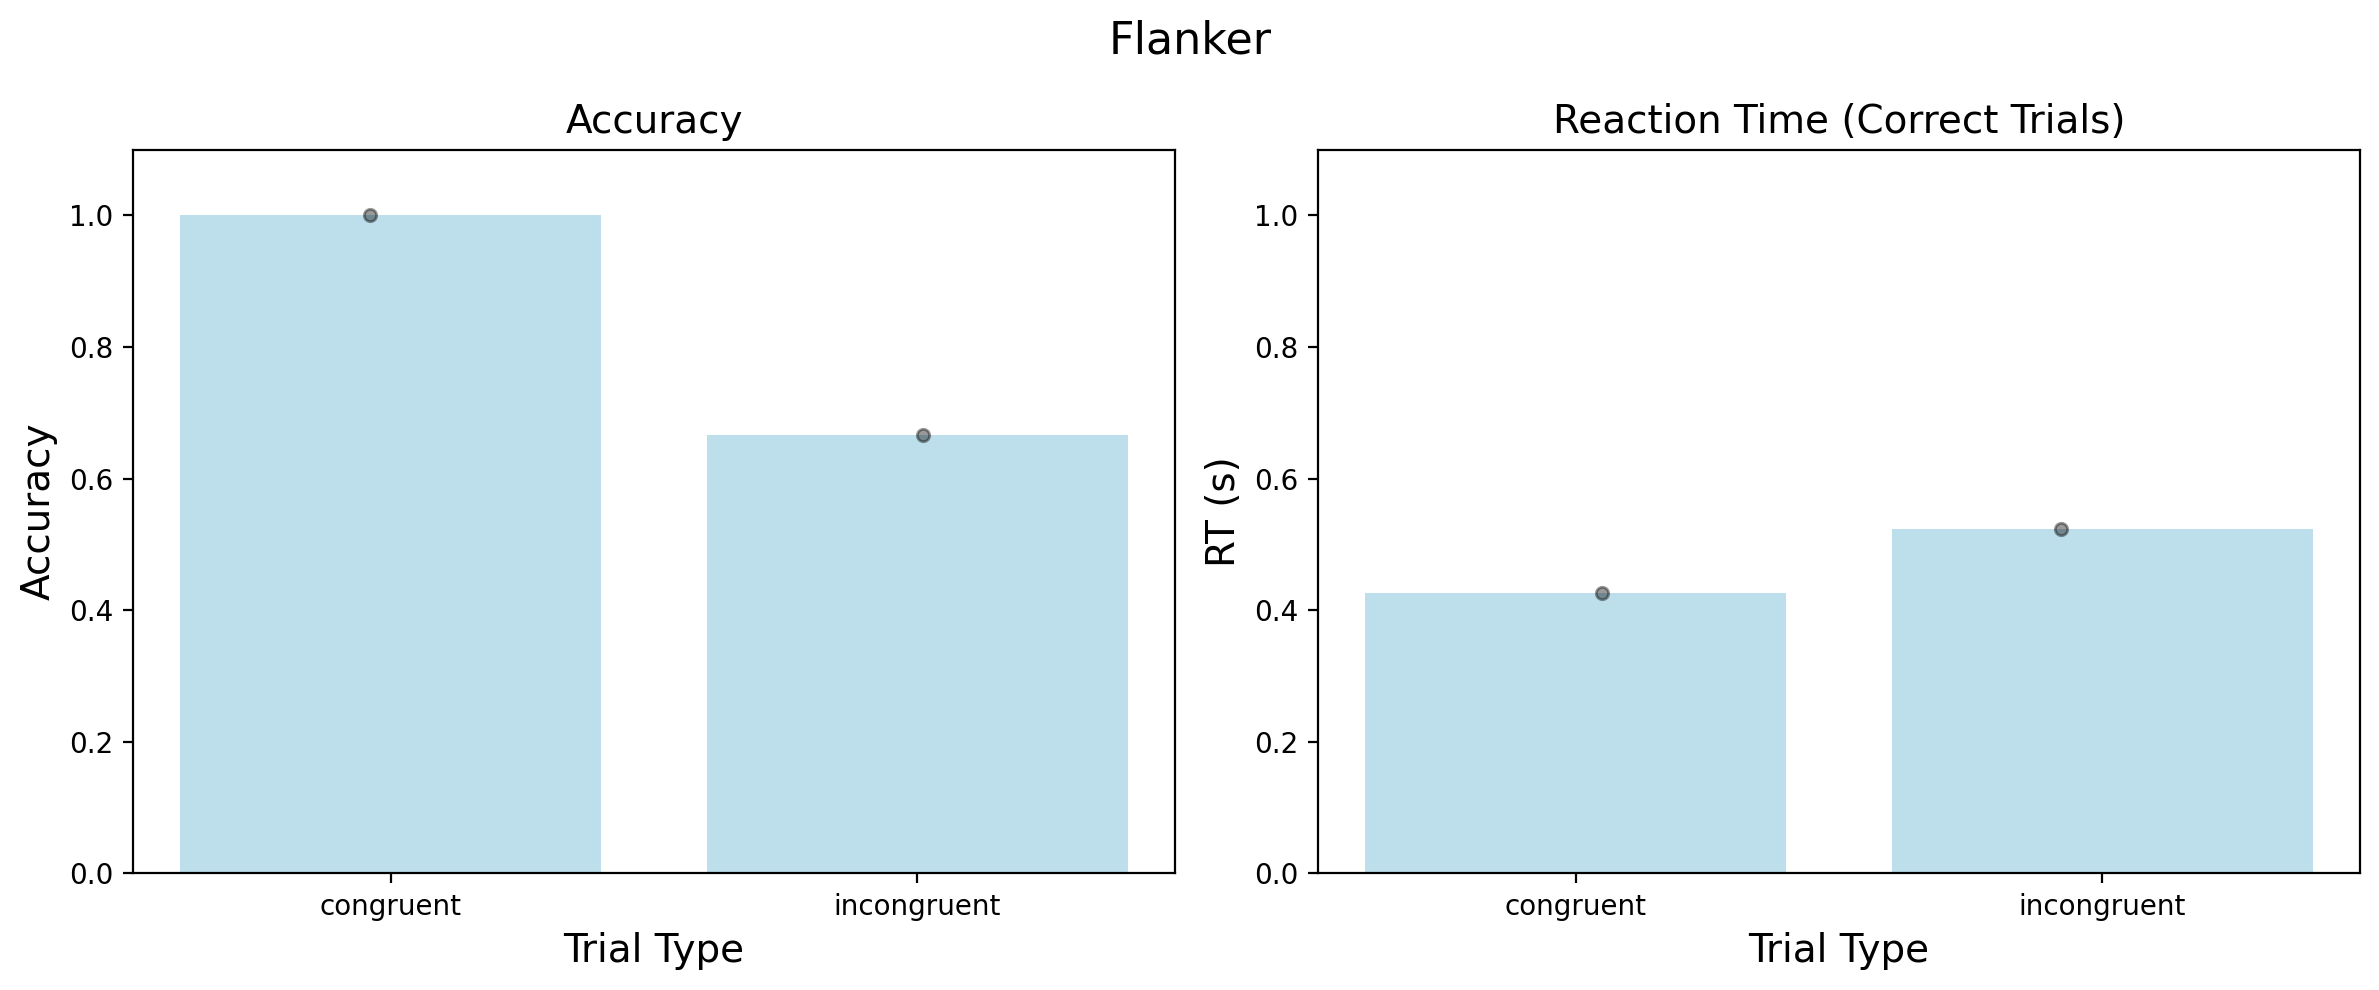

In [55]:
df_flanker = load_data('flanker.csv')

# Calculate stats per subject and type
stats_acc = df_flanker.groupby(['subject_id', 'type'])['correct'].mean().reset_index()
stats_rt = df_flanker[df_flanker['correct'] == 1].groupby(['subject_id', 'type'])['rt'].mean().reset_index()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
plt.suptitle('Flanker', fontsize=16)
types = ['congruent', 'incongruent']
x_indices = [0, 1]

for i, (metric_df, ax, ylabel, title) in enumerate([
    (stats_acc, axes[0], 'Accuracy', 'Accuracy'),
    (stats_rt, axes[1], 'RT (s)', 'Reaction Time (Correct Trials)')
]):
    col = 'correct' if i == 0 else 'rt'
    means = [metric_df[metric_df['type'] == t][col].mean() for t in types]
    ax.bar(types, means, color='lightblue', alpha=0.8)
    
    for j, t in enumerate(types):
        vals = metric_df[metric_df['type'] == t][col]
        ax.scatter(add_jitter(np.repeat(j, len(vals))), vals, color='black', alpha=0.4, s=20)
    
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Trial Type', fontsize=14)
    ax.set_ylim(0,1.1)

plt.tight_layout()
plt.savefig('flanker_analysis.png')
plt.show()

In [7]:
# Top Performer
subject_stats = df_flanker.groupby('subject_id').agg({'correct': 'mean', 'rt': 'mean'}).reset_index()
top_performer = subject_stats.sort_values(by=['correct', 'rt'], ascending=[False, True]).iloc[0]
print(f"Top Performer: {top_performer['subject_id']} (Acc: {top_performer['correct']:.2%}, Avg RT: {top_performer['rt']:.3f}s)")

Top Performer: chris (Acc: 83.33%, Avg RT: 0.448s)


## N-Back Task

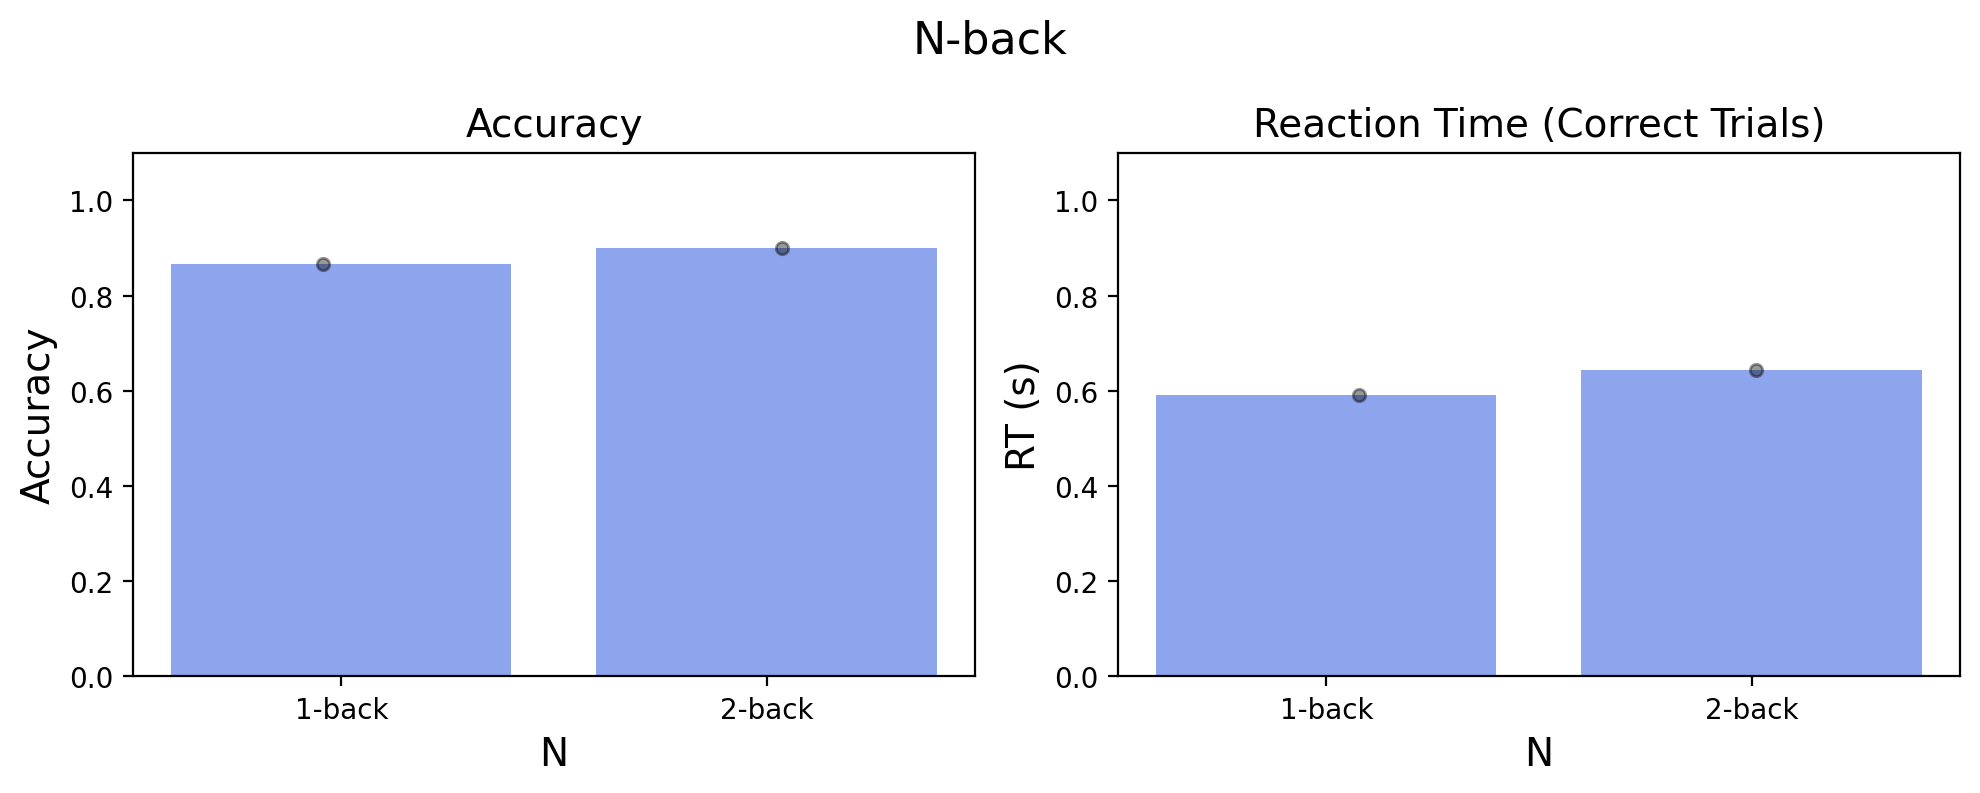

In [54]:
df_nback = load_data('nback.csv')

stats_acc = df_nback.groupby(['subject_id', 'n'])['correct'].mean().reset_index()
stats_rt = df_nback[df_nback['correct'] == 1].groupby(['subject_id', 'n'])['rt'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
plt.suptitle('N-back', fontsize=16)
n_values = sorted(df_nback['n'].unique())

for i, (metric_df, ax, ylabel, title) in enumerate([
    (stats_acc, axes[0], 'Accuracy', 'Accuracy'),
    (stats_rt, axes[1], 'RT (s)', 'Reaction Time (Correct Trials)')
]):
    col = 'correct' if i == 0 else 'rt'
    means = [metric_df[metric_df['n'] == n][col].mean() for n in n_values]
    ax.bar([f"{n}-back" for n in n_values], means, color='royalblue', alpha=0.6)
    
    for j, n in enumerate(n_values):
        vals = metric_df[metric_df['n'] == n][col]
        ax.scatter(add_jitter(np.repeat(j, len(vals))), vals, color='black', alpha=0.4, s=20)
    
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('N', fontsize=14)
    ax.set_ylim(0,1.1)

plt.tight_layout()
plt.savefig('nback_analysis.png')
plt.show()

In [13]:
# Top Performer
subject_stats = df_nback.groupby('subject_id').agg({'correct': 'mean', 'rt': 'mean'}).reset_index()
top_performer = subject_stats.sort_values(by=['correct', 'rt'], ascending=[False, True]).iloc[0]
print(f"Top Performer: {top_performer['subject_id']} (Acc: {top_performer['correct']:.2%}, Avg RT: {top_performer['rt']:.3f}s)")

Top Performer: chris (Acc: 88.33%, Avg RT: 0.604s)


## Serial Reaction Time Task

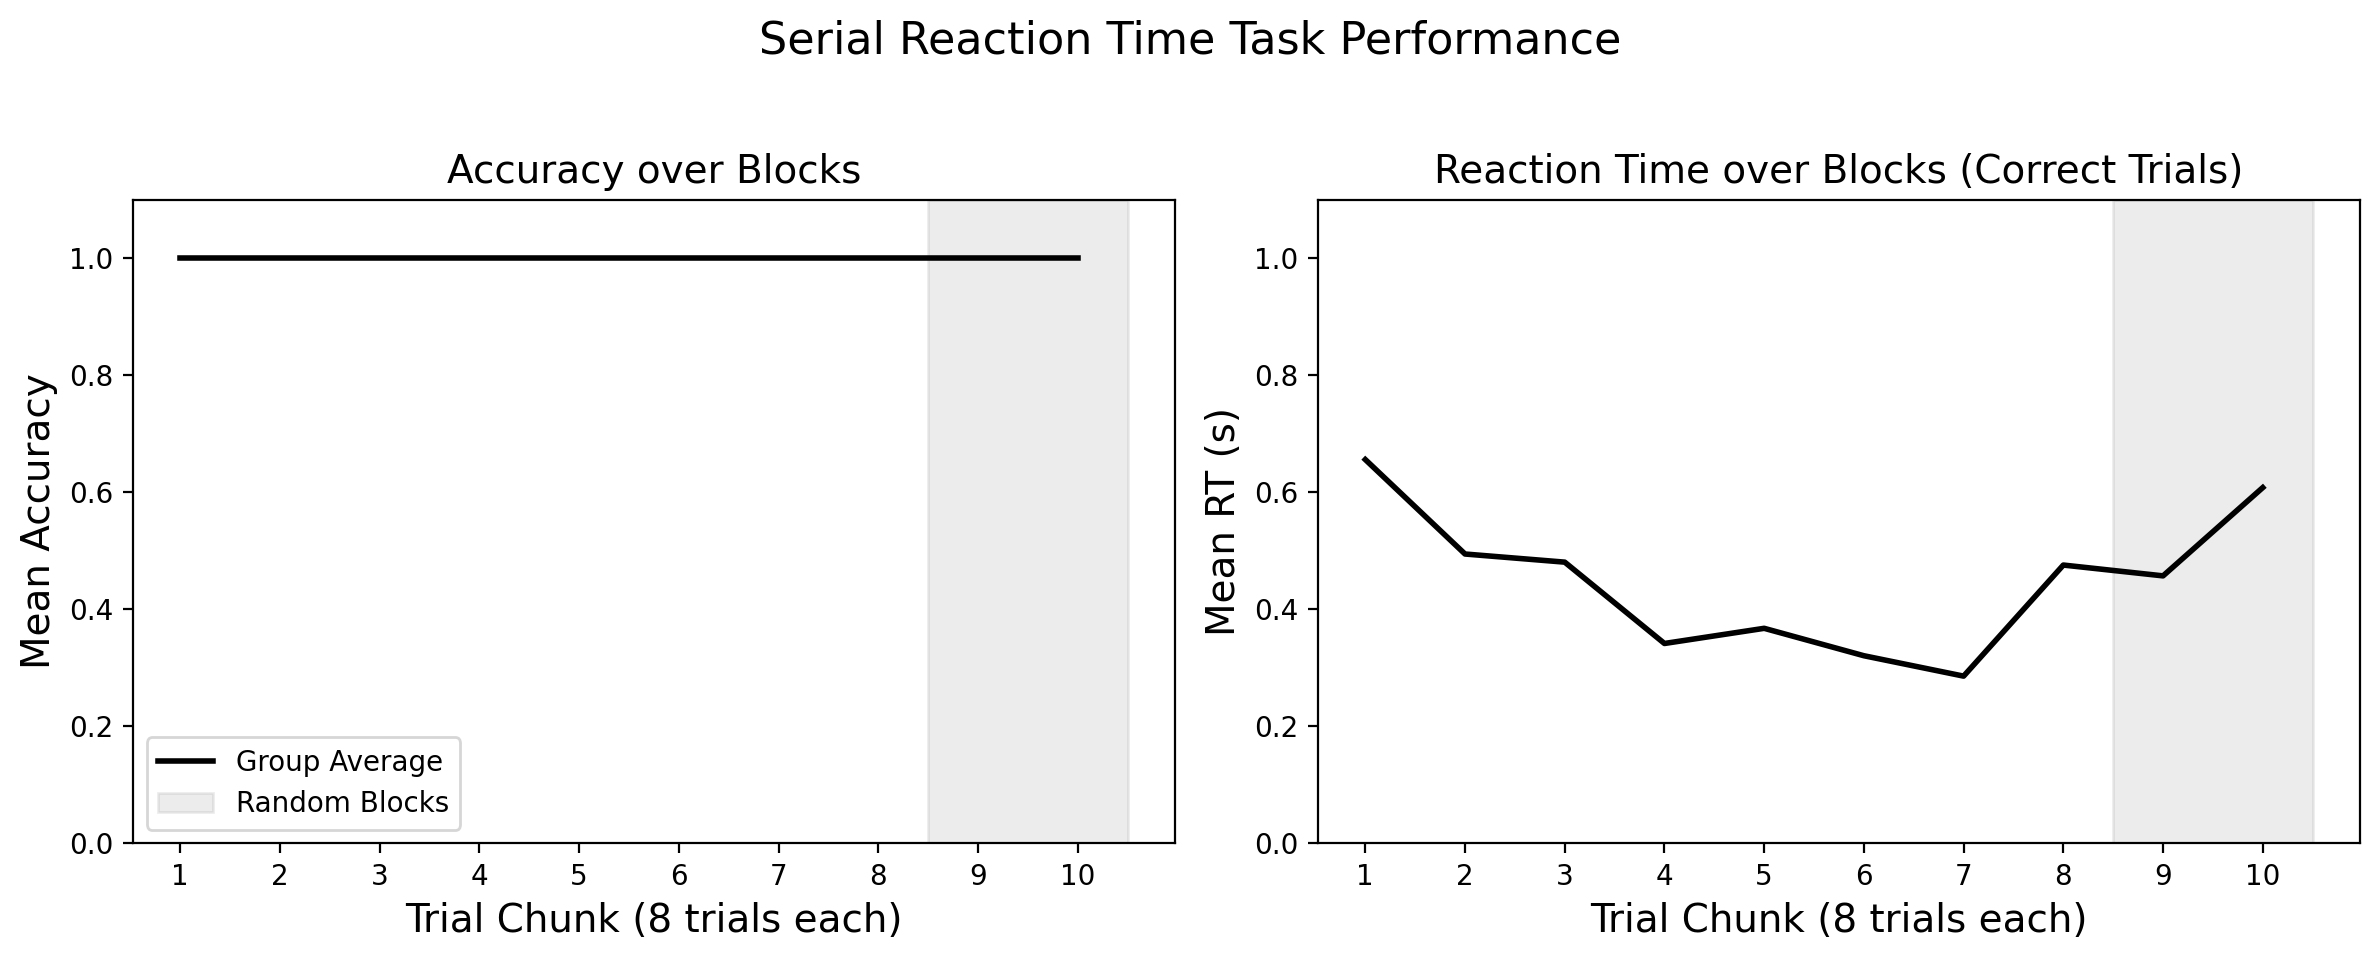

In [56]:
df_srtt = load_data('srtt.csv')

if df_srtt is not None:
    # Create chunks of 8 trials
    df_srtt['chunk'] = (df_srtt['trial'] // 8) + 1
    
    # Calculate stats per subject per chunk
    acc_chunks = df_srtt.groupby(['subject_id', 'chunk'])['correct'].mean().reset_index()
    rt_chunks = df_srtt[df_srtt['correct'] == 1].groupby(['subject_id', 'chunk'])['rt'].mean().reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
    plt.suptitle('Serial Reaction Time Task Performance', fontsize=16)

    for i, (metric_df, ax, ylabel, title) in enumerate([
        (acc_chunks, axes[0], 'Mean Accuracy', 'Accuracy over Blocks'),
        (rt_chunks, axes[1], 'Mean RT (s)', 'Reaction Time over Blocks (Correct Trials)')
    ]):
        col = 'correct' if i == 0 else 'rt'
        
        # Individual subject lines
        for subj in metric_df['subject_id'].unique():
            subj_data = metric_df[metric_df['subject_id'] == subj]
            ax.plot(subj_data['chunk'], subj_data[col], color='gray', alpha=0.3, linewidth=1)
        
        # Group average
        group_avg = metric_df.groupby('chunk')[col].mean()
        ax.plot(group_avg.index, group_avg.values, color='black', linewidth=2, label='Group Average')
        
        # Highlight random chunks (9 and 10)
        ax.axvspan(8.5, 10.5, color='gray', alpha=0.15, label='Random Blocks')
        
        ax.set_xlabel('Trial Chunk (8 trials each)', fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_xticks(range(1, 11))
        ax.set_ylim(0,1.1)
        if i == 0: ax.legend(loc='lower left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('srtt_analysis.png')
    plt.show()

In [57]:
# Top Performer (Acc -> RT)
subject_stats = df_srtt.groupby('subject_id').agg({'correct': 'mean', 'rt': 'mean'}).reset_index()
top_performer = subject_stats.sort_values(by=['correct', 'rt'], ascending=[False, True]).iloc[0]
print(f"Top Performer: {top_performer['subject_id']} (Acc: {top_performer['correct']:.2%}, Avg RT: {top_performer['rt']:.3f}s)")


Top Performer: chris (Acc: 100.00%, Avg RT: 0.445s)


## Paired Associate Memory Task

Accuracy Leaderboard:
  2. chris2: 50.00%
  1. chris: 20.00%
  3. chris3: 10.00%


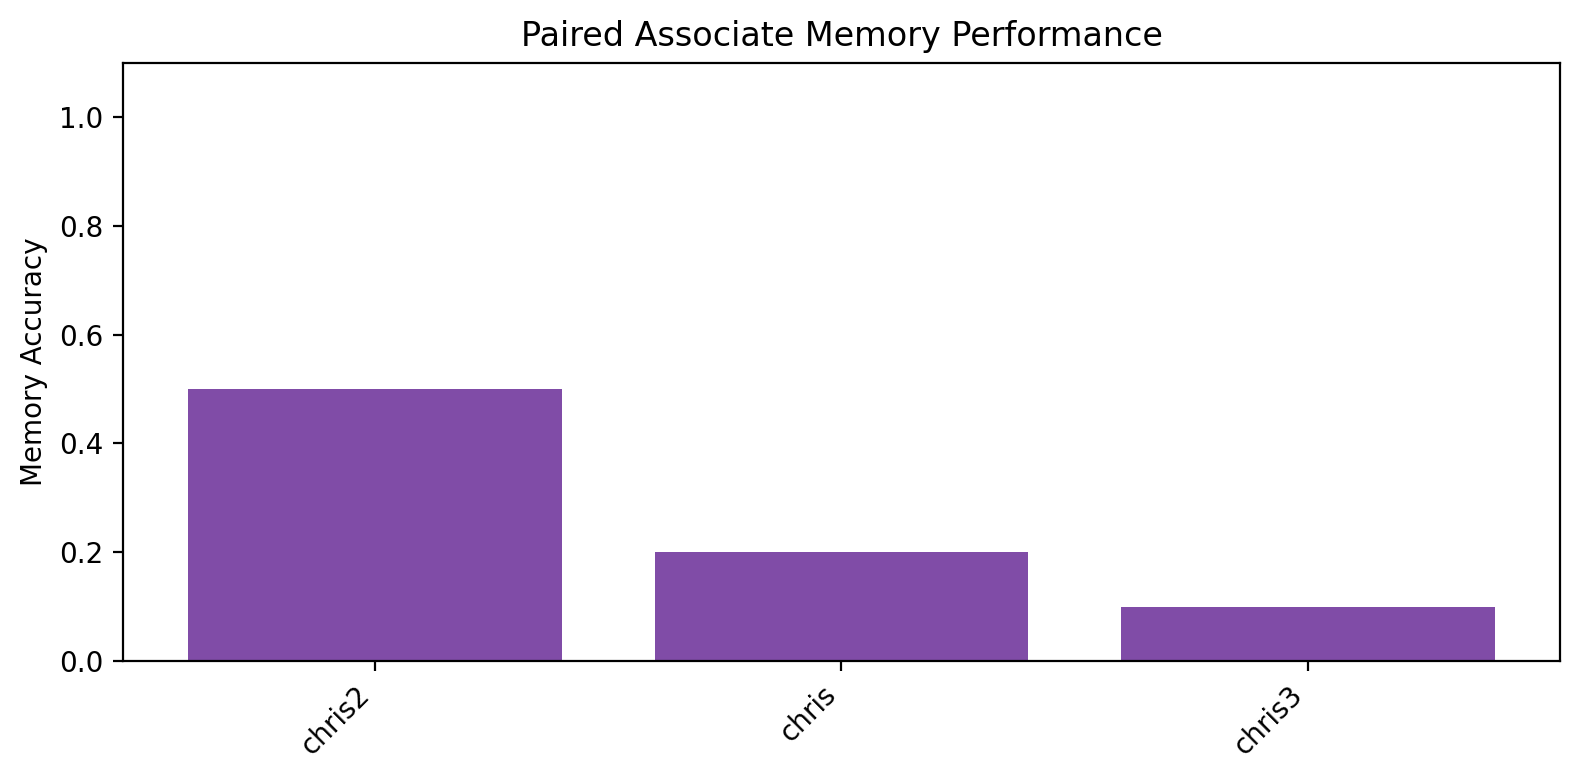

In [73]:
df_pa = load_data('paired_associate.csv')
df_pa_test = df_pa[df_pa['phase'] == 'test']

# Calculate accuracy per subject
subj_acc = df_pa_test.groupby('subject_id')['correct'].mean().reset_index()
subj_acc = subj_acc.sort_values(by='correct', ascending=False)

plt.figure(figsize=(8, 4), dpi=200)
plt.bar(subj_acc['subject_id'], subj_acc['correct'], color='indigo',alpha=0.7)
plt.ylabel('Memory Accuracy')
plt.title('Paired Associate Memory Performance')
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1.1)
plt.tight_layout()
plt.savefig('paired_associate_analysis.png')

# Print accuracy leaderboard
print("Accuracy Leaderboard:")
for i, row in subj_acc.iterrows():
    print(f"  {i+1}. {row['subject_id']}: {row['correct']:.2%}")

plt.show()